<a href="https://colab.research.google.com/github/rohanjsheth/Nba-Shot-Graph/blob/main/ToyDiffusionMINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [26]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [25]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 9, 4, 0, 0, 3, 4, 7])


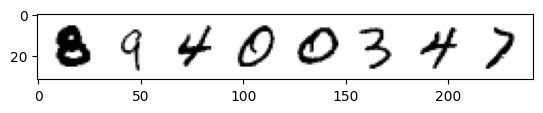

In [24]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [27]:
def corrupt(img, amount):
  noise = torch.rand_like(img)
  amount = amount.view(-1, 1, 1, 1)
  return img*(1-amount) + noise*amount

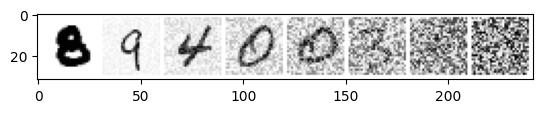

In [28]:
corr = corrupt(x, torch.linspace(0, 1, x.shape[0]))
plt.imshow(torchvision.utils.make_grid(corr)[0], cmap='Greys');

In [52]:
#UNET
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
      super().__init__()
      self.down = torch.nn.ModuleList([
          nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
          nn.Conv2d(32, 64, kernel_size=5, padding=2),
          nn.Conv2d(64, 64, kernel_size=5, padding=2)
      ])
      self.up = torch.nn.ModuleList([
          nn.Conv2d(64, 64, kernel_size=5, padding=2),
          nn.Conv2d(64, 32, kernel_size=5, padding=2),
          nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
      ])
      self.activation = nn.SiLU()
      self.downscale = nn.MaxPool2d(2)
      self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
      h = []
      for i, l in enumerate(self.down):
        #print(f"x_in: {x.shape}")
        x = self.activation(l(x))
        if i < 2:
          h.append(x)
          x = self.downscale(x)
      for i, l in enumerate(self.up):
        #print(f"x_out: {x.shape}")
        #print(f"h: {h[-1].shape}")
        if i > 0:
          x = self.upscale(x)
          x += h.pop()
        x = self.activation(l(x))
      return x

In [53]:
net = BasicUNet()
x = torch.rand(1, 1, 28, 28)
net(x).shape

torch.Size([1, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.026102
Finished epoch 1. Average loss for this epoch: 0.020047
Finished epoch 2. Average loss for this epoch: 0.018471


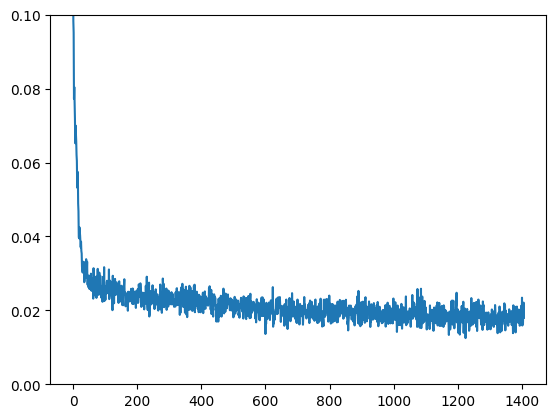

In [54]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
  for x, y in train_dataloader:
    x = x.to(device)
    noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
    noisy_x = corrupt(x, noise_amount)

    pred = net(noisy_x)
    loss = loss_fn(pred, x)

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

  avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
  print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(losses)
plt.ylim(0, 0.1);

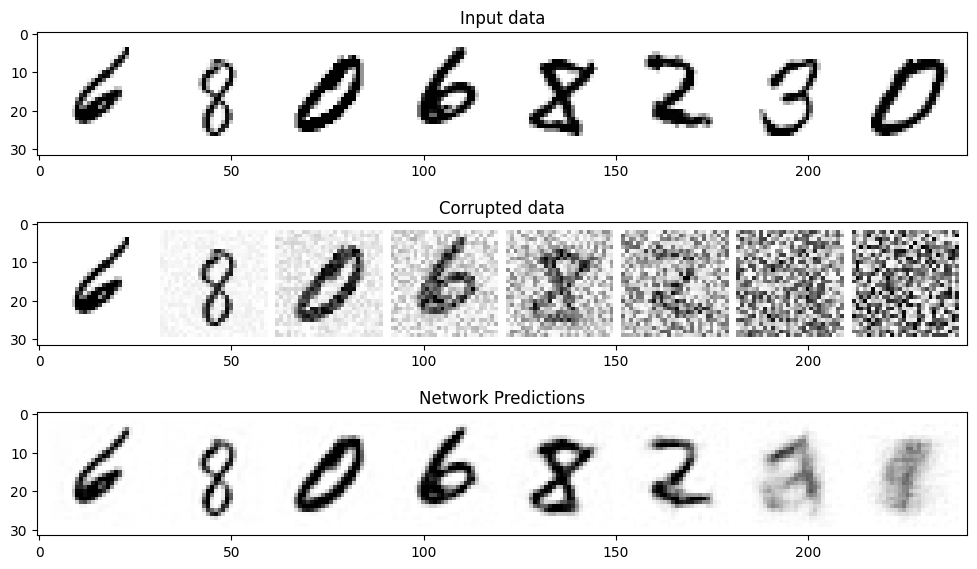

In [56]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

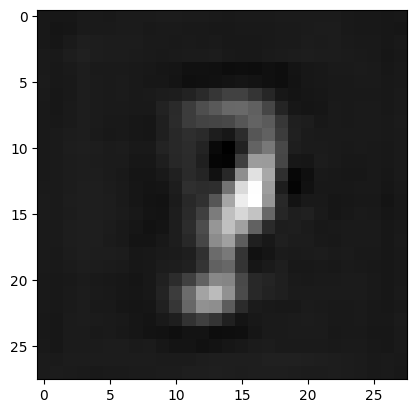

In [67]:
def iterative_sample():
  x = torch.rand(1, 1, 28, 28)
  x = x.to(device)
  for i in range(4):
    x = net(x)
  x = x.detach().cpu()
  plt.imshow(x.squeeze(), cmap='gray')

iterative_sample()